Gyroid形状のグラフェンをデザインする。

炭素原子の分子動力学法を行う。ただし、以下の拘束条件により$\textrm{sp}^2$炭素になるようにする。

* 原子間に働く力はMorseポテンシャルとする。ただし、すべての原子対に働くわけではない。
$$U(r)=D_m\left( 1 - \exp[-a(r-r_0)]\right)^2$$
* ある原子$i$から見て、最近接3原子と$i$の間には短距離相互作用($r_0=1$)が働く。
* 短距離相互作用の対象である3原子の間には、相互に遠距離相互作用($r_0=\sqrt{3}$)が働く。
* ある原子$i$からみて、最近接10原子(最近接3原子は除外する)との間には、遠距離相互作用($r_0=\sqrt{3}$)が働く。
* 上の3条件が複数あてはまる対に関しては、遠距離相互作用を優先する。(対相互作用は足しあわせない)

さらに、ジャイロイド形状になるように、以下の外場を加える。
$$U(x,y,z)=D_g\cdot \left[\sin(2\pi x/L)\cos(2\pi y/L)+\sin(2\pi y/L)\cos(2\pi z/L)+\sin(2\pi z/L)\cos(2\pi x/L)\right]^2$$


ポテンシャルエネルギーを座標で微分すると力(ベクトル)が得られる。

$$\vec{F}=-{\partial U\over \partial\vec{r}}=-{\vec{r}\over |r|}{\partial U(r)\over \partial r}$$


In [ ]:
import sympy

r,l,s,a = sympy.symbols("r l s a")

# sympy.diff(sympy.exp(-(r-l)**2/s**2), r)
U = (1-sympy.exp(-a*(r-l)))**2
sympy.diff(U, r)

In [ ]:
x,y,z,L = sympy.symbols("x y z L")
U = (sympy.sin(x*2*sympy.pi/L)*sympy.cos(y*2*sympy.pi/L)+sympy.sin(y*2*sympy.pi/L)*sympy.cos(z*2*sympy.pi/L)+sympy.sin(z*2*sympy.pi/L)*sympy.cos(x*2*sympy.pi/L))**2
sympy.diff(U,x), sympy.diff(U,y), sympy.diff(U,z)

Quenchする場合は、力の方向に少しずつ座標を動かせばいい。
$$\Delta \vec r=A\vec F$$

MDでアニールする場合は、運動方程式を数値的に解きつつ、運動エネルギーを削いでいく。
$$\Delta \vec v=(\vec F/m ) \Delta t$$
$$\Delta \vec r=\vec v \Delta t$$
$$E_k={1\over 2}\sum_i m_i |v_i|^2$$
$$\vec v_\mathrm{new} = \vec v \times 0.98$$



In [ ]:
import pairlist as pl
import numpy as np
import yaplotlib as yap
import itertools as it
from logging import getLogger, basicConfig, INFO, StreamHandler

N = 288  # 一番小さいサイズでもこんなになる。これで自発的に結晶になる気がしない。
# T = 1.0  # temperature

# 論文にあったセルサイズ
# Owens, J. R., Daniels, C., Nicolaï, A., Terrones, H. & Meunier, V. Structural, energetic, and electronic properties of gyroidal graphene nanostructures. Carbon N. Y. 96, 998–1007 (2016)
G3cell = 16.05
# Grapheneの共有結合長
CC = 1.42  # Graphene; https://en.wikipedia.org/wiki/Graphene
# 結合長を1とした場合のセルサイズ
L = G3cell / CC  # cell size

# 平衡距離
l0 = 1.0  # 短距離
l1 = 3**0.5  # 長距離
# 相互作用のカットオフ距離。全対について計算するわけではないので、この距離は近接対を抽出する目的にのみ使っている。
rc = l1 * 2

# Morse関数の、指数関数の中の係数
a = 3.0  # morse's a

# シミュレーションセル(立方体)
cell = np.diag([L, L, L])

In [ ]:
def force(x):
    neis = [{} for i in range(N)]
    for i, j, d in pl.pairs_iter(x, rc, cell, fractional=False):
        neis[i][j] = d
        neis[j][i] = d

    interactions = dict()
    for i in range(N):
        argnei = sorted(neis[i], key=lambda j: neis[i][j])
        # 近くにいる原子とは遠隔結合。
        for j in argnei[3:10]:
            interactions[i, j] = "R"
            interactions[j, i] = "R"
        # ただし最近接3つとは近距離結合。ただし遠隔結合を優先する
        for j in argnei[:3]:
            if (i, j) not in interactions:
                interactions[i, j] = "A"
                interactions[j, i] = "A"
        # それら3つの間は遠隔結合
        for j, k in it.combinations(argnei[:3], 2):
            interactions[k, j] = "R"
            interactions[j, k] = "R"

    F = np.zeros([N, 3])
    E = 0
    for i, j in interactions:
        if i < j:
            if interactions[i, j] == "A":
                # 近接結合
                ll = l0
            else:
                # 遠隔結合
                ll = l1
            d = x[i] - x[j]
            d -= np.floor(d / L + 0.5) * L
            r = np.linalg.norm(d)
            e = d / r
            # morse potential
            ex = np.exp(-a * (r - ll))
            f = -e * 2 * a * (1 - ex) * ex
            E += (1 - ex) ** 2
            F[i] += f
            F[j] -= f
    # assert False

    # さらに、Gyroidの外場を加える。
    rx, ry, rz = (2 * np.pi * x / L).T

    Ug = np.sin(rx) * np.cos(ry) + np.sin(ry) * np.cos(rz) + np.sin(rz) * np.cos(rx)
    fx, fy, fz = (
        (-np.sin(rx) * np.sin(rz) + np.cos(rx) * np.cos(ry)) * Ug * 4 * np.pi / L,
        (-np.sin(rx) * np.sin(ry) + np.cos(ry) * np.cos(rz)) * Ug * 4 * np.pi / L,
        (-np.sin(ry) * np.sin(rz) + np.cos(rx) * np.cos(rz)) * Ug * 4 * np.pi / L,
    )
    Dg = 5  # force const
    F -= np.array([fx, fy, fz]).T * Dg
    E += np.sum(Ug**2) * Dg

    return F, E



# 三角形にならないようにしたい。どうする?ある分子から見て、最近接の3原子とはl0相互作用する。

In [226]:
from cycless import cycles, simplex
import networkx as nx


def snapshot(x, bondlen=l0 * 1.2, verbose=True):
    """yaplot化。ついでに配位数を数える。

    Args:
        x (_type_): _description_
        bondlen (_type_, optional): _description_. Defaults to l0*1.2.

    Returns:
        _type_: _description_
    """


    logger = getLogger()

    frame = ""

    frame += yap.Size(0.2)
    for pos in x:
        frame += yap.Circle(pos)
    nnei = [0] * len(x)
    g = nx.Graph()
    edges = {}
    for i, j, d in pl.pairs_iter(x, bondlen, cell, fractional=False):
        edges[i, j] = 0
        edges[j, i] = 0
        nnei[i] += 1
        nnei[j] += 1

    hist = [0] * 10
    for i in nnei:
        if i > 9:
            i = 0
        hist[i] += 1
    if verbose:
        logger.info(f"{hist} Coords")

    g = nx.Graph(
        [(i, j) for i, j, d in pl.pairs_iter(x, bondlen, cell, fractional=False)]
    )

    frame += yap.Layer(3)
    tetras = [tetra for tetra in simplex.tetrahedra_iter(g)]
    for tetra in tetras:
        for i, j in it.combinations(tetra, 2):
            edges[i, j] = 3
            edges[j, i] = 3
    if verbose:
        logger.info(f"{len(tetras)} Tetras")

    if len(tetras) == 0:
        frame += yap.Layer(4)
        frame += yap.Color(4)
        hist = [0] * 6
        for cycle in cycles.cycles_iter(g,maxsize=5):
            cycle = list(cycle)
            hist[len(cycle)] += 1
            if len(cycle) > 3:
                d = x[cycle] - x[cycle[0]]
                d -= np.floor(d / L + 0.5) * L
                d += x[cycle[0]]
                frame += yap.Polygon(d)
                
        if verbose:
            logger.info(f"{hist} Cycles")


    frame += yap.Layer(2)
    for (i, j), palette in edges.items():
        frame += yap.Color(palette)
        d = x[j] - x[i]
        d -= np.floor(d / L + 0.5) * L
        frame += yap.Line(x[i], x[i] + d)

    frame += yap.NewPage()

    return frame

In [ ]:
import sys

# Quenching
logger = getLogger()
basicConfig(level=INFO)
# logger.addHandler(StreamHandler(stream=sys.stdout))

N = 288

x = np.random.random([N, 3]) * L
dt = 0.01

with open("quench.yap", "w") as f:
    f.write("")

for loop in range(1000):
    F, E = force(x)
    if loop % 10 == 0:
        logger.info((loop, E / N))
    # print(F)

    # overdamped action
    x += F * dt

    x -= np.floor(x / L + 0.5) * L

    with open("quench.yap", "a") as f:
        f.write(snapshot(x))

In [ ]:

logger = getLogger()
basicConfig(level=INFO)

x = np.random.random([N, 3]) * L
v = np.zeros([N, 3])
dt = 0.02

with open("anneal.yap", "w") as f:
    f.write("")

for loop in range(10000):
    F, E = force(x)
    # print(F)

    # solve the equation of motion numerically
    v += F * dt / 2
    x += v * dt
    x -= np.floor(x / L + 0.5) * L

    # energy monitor
    ek = np.sum(v**2) / 2

    # annealer
    v *= 0.95

    if loop % 10 == 0:
        logger.info((loop, ek / N, E / N))
        with open("anneal.yap", "a") as f:
            f.write(snapshot(x))

    v += F * dt / 2



しかし、どちらの方法でもきれいな構造を得ることは難しいので、Replica Exchange MDを行い、構造の改善を試みる。

レプリカ交換法では、異なる温度のシミュレーションを平行で実行し、時々Boltzmann重みに従ってエネルギーの交換を行う。

系1の温度とエネルギーが$(T_1, U_1)$、系2の温度とエネルギーが$(T_2, U_2)$であるとする。(温度とエネルギーの単位はそろえた)

* 系1のエネルギーが次の瞬間に$U_2$になる確率は$\exp\left(-{U_2-U_1\over T_1}\right)$である。
* 系2のエネルギーが次の瞬間に$U_1$になる確率は$\exp\left(-{U_1-U_2\over T_2}\right)$である。
* これらが同時に起こる確率は$p=\exp\left(-{U_2-U_1\over T_1}\right)\cdot \exp\left(-{U_1-U_2\over T_2}\right)$
   $=\exp\left((U_2-U_1)({1\over T_2}-{1\over T_1})\right)$と書ける。
* 通常のMetropolisサンプリングの要領で、$p$が1より大きいなら無条件に受け入れ、$p$が1未満なら確率$p$で受けいれればいい。

まず、温度一定のMDを実装する。上のクエンチとアニールの結果から アニール系のポテンシャルエネルギーがQ構造のポテンシャルエネルギーに近い時の、アニール系の運動エネルギー0.02あたりが適温に思える。

In [ ]:
logger = getLogger()
basicConfig(level=INFO)

dt = 0.02

with open("T0.004.yap", "w") as f:
    f.write("")


def onestep(x, v, T):
    F, E = force(x)
    # print(F)

    # solve the equation of motion numerically
    v += F * dt / 2
    x += v * dt
    x -= np.floor(x / L + 0.5) * L

    # energy monitor
    ek = np.sum(v**2) / 2 / N

    # T controller
    if ek > T:
        v *= 0.95
    else:
        v *= 1.05

    v += F * dt / 2
    return x, v, ek, E / N


x = np.random.random([N, 3]) * L
v = np.zeros([N, 3])

for loop in range(10000):
    x, v, Ek, Ep = onestep(x,v,T=0.02)

    if loop % 10 == 0:
        logger.info((loop, Ek, Ep))
        with open("T0.004.yap", "a") as f:
            f.write(snapshot(x))


In [ ]:
import random

logger = getLogger()
basicConfig(level=INFO)

dt = 0.02

with open("T0.001.yap", "w") as f:
    f.write("")


Ts = [0.001, 0.002, 0.005, 0.01, 0.02, 0.05]
xs = [np.random.random([N, 3]) * L for i in range(len(Ts))]
vs = [np.zeros([N, 3]) for i in range(len(Ts))]

for loop in range(1000):
    for innerloop in range(10):
        newx = []
        newv = []
        Eps = []
        for i, T in enumerate(Ts):
            x, v, Ek, Ep = onestep(xs[i],vs[i],T=T)
            newx.append(x)
            newv.append(v)
            Eps.append(Ep)
            if innerloop == 0:
                logger.info(f"{loop} {Ek} {Ep}")
        xs, vs = newx, newv

    for i in range(len(Ts)-1):
        T1, U1 = Ts[i], Eps[i]
        T2, U2 = Ts[i+1], Eps[i+1]
        
        p = np.exp((U2-U1)*(1/T2-1/T1))
        if p > random.random():
            xs[i], xs[i+1] = xs[i+1], xs[i]
            vs[i], vs[i+1] = vs[i+1], vs[i]
            Eps[i], Eps[i+1] = Eps[i+1], Eps[i]
            logger.info(f"Succeeded exchange between {T1} and {T2}.")

    with open("T0.001.yap", "a") as f:
        f.write(snapshot(xs[0]))


とりあえず動くようにはなった。だが、きれいな網目ができるケースはない。

こういう力技では美しい構造を見付けることはできないのかもしれない。そうなると、トポロジーベースの手法が必要。だがどうやって。

例えば、Stone-Walesのアルゴリズムで修正を続けるという手はある。だがその場合には、まず適度な(欠陥のない)初期配置が必要。あと、Stone-Walesは辺の本数を変えないので、大穴は大穴のままになってしまう。

堂寺のように、剛体球をパッキングしてから、一部を抜いてsp2化することはできるか?

あるいはボロノイ、か。それはいけるかも。環それぞれをボロノイ面とみなし、剛体球のパッキングからボロノイ多角形を作り、あとはStone-Walesでチューニングする。

8角形とかが出てくるとやっかいそうだ。

あと、Pythonはやはりこういう計算には遅すぎる。せめてJavaScriptにしたい。

In [232]:
import matplotlib.pyplot as plt

def force2(x, n=2, a=4, Dg=250, rc=l1*3, plt=None, peak=False):
    """
    反発のみにして、長さの尺度を消す。
    """
    
    neis = [{} for i in range(N)]
    interactions = dict()
    ds = []
    for i, j, d in pl.pairs_iter(x, rc, cell, fractional=False):
        neis[i][j] = d
        neis[j][i] = d
        ds.append(d)
        # interactions[i, j] = "A"
        # interactions[j, i] = "A"
    H = np.histogram(ds, bins=30)
    for i in range(len(H[0])-1):
        if H[0][i] > H[0][i+1]:
            break
    if peak:
        rpeak = (H[1][i] + H[1][i+1])/2
    if plt is not None:
        H =plt.hist(ds, bins=30, color="gray")
        plt.stem(rpeak,100)
        plt.show()

    for i in range(N):
        argnei = sorted(neis[i], key=lambda j: neis[i][j])
        for j in argnei[:8]:
            interactions[i, j] = "A"
            interactions[j, i] = "A"

    F = np.zeros([N, 3])
    E = 0
    for i, j in interactions:
        if i < j:
            d = x[i] - x[j]
            d -= np.floor(d / L + 0.5) * L
            r = np.linalg.norm(d)
            e = d / r

            # repulsion
            E += a / r**n
            f = -n * e * a / r ** (n + 1)
            F[i] -= f
            F[j] += f
    # assert False
    # logger.info(f"{E} PE(1)")

    # さらに、Gyroidの外場を加える。
    rx, ry, rz = (2 * np.pi * x / L).T

    Ug = np.sin(rx) * np.cos(ry) + np.sin(ry) * np.cos(rz) + np.sin(rz) * np.cos(rx)
    fx, fy, fz = (
        (-np.sin(rx) * np.sin(rz) + np.cos(rx) * np.cos(ry)) * Ug * 4 * np.pi / L,
        (-np.sin(rx) * np.sin(ry) + np.cos(ry) * np.cos(rz)) * Ug * 4 * np.pi / L,
        (-np.sin(ry) * np.sin(rz) + np.cos(rx) * np.cos(rz)) * Ug * 4 * np.pi / L,
    )
    # Dg = 250  # force const
    F -= np.array([fx, fy, fz]).T * Dg
    # logger.info(f"{np.sum(Ug**2) * Dg} PE(2)")
    E += np.sum(Ug**2) * Dg

    if peak:
        return F, E, rpeak
    return F,E

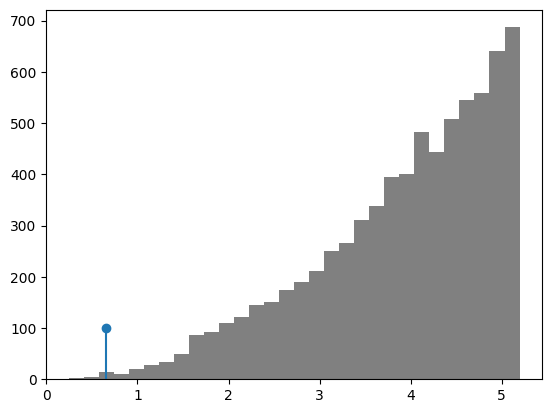

ValueError: too many values to unpack (expected 2)

In [216]:
import sys

# Quenching
logger = getLogger()
basicConfig(level=INFO)
# logger.addHandler(StreamHandler(stream=sys.stdout))

N = 288 * 2 // 3 - 3

x = np.random.random([N, 3]) * L
dt = 0.001

with open("quench2.yap", "w") as f:
    f.write("")

for loop in range(1000):
    F, E = force2(x, n=5)
    if loop % 10 == 0:
        logger.info((loop, E / N))
    # print(F)

    # overdamped action
    x += F * dt

    x -= np.floor(x / L + 0.5) * L

    # 長さをどうするかは検討の余地あり。一応、Gyroidの表面積から推定はできるが表面積がわからない。
    with open("quench2.yap", "a") as f:
        f.write(snapshot(x, l1 * 1.15))

| atoms | Dg | n |(3,4)-cycles |
|-------|---------|-------|---|
|189 | 250 | 2 | 329, 16|
|189 | 250 | 3 | 360, 14|
|189 | 250 | 4 | 360, 14|
|189|250 |5| (tetra remains)|

マジックナンバーをさがすだけならQuenchで十分か。

論文にのっていた個数がマジックナンバーになるかどうかを検証しよう。

In [ ]:

logger = getLogger()
basicConfig(level=INFO)

x = np.random.random([N, 3]) * L
v = np.zeros([N, 3])
dt = 0.005

with open("anneal2.yap", "w") as f:
    f.write("")

for loop in range(10000):
    F, E = force2(x,n=4)
    # print(F)

    # solve the equation of motion numerically
    v += F * dt / 2
    x += v * dt
    x -= np.floor(x / L + 0.5) * L

    # energy monitor
    ek = np.sum(v**2) / 2

    # annealer
    v *= 0.93

    if loop % 10 == 0:
        logger.info((loop, ek / N, E / N))
        with open("anneal2.yap", "a") as f:
            f.write(snapshot(x, l1*1.15))

    v += F * dt / 2



In [ ]:
| atoms | Dg | n |(3,4)-cycles |
|-------|---------|-------|---|
|189 | 250 | 4 | 371,10|


In [ ]:
logger = getLogger()
basicConfig(level=INFO)

dt = 0.005

with open("T0.004-2.yap", "w") as f:
    f.write("")


N = 192

def onestep2(x, v, T):
    F, E = force2(x, n=4)
    # print(F)

    # solve the equation of motion numerically
    v += F * dt / 2
    x += v * dt
    x -= np.floor(x / L + 0.5) * L

    # energy monitor
    ek = np.sum(v**2) / 2 / N

    # T controller
    if ek > T:
        v *= 0.95
    else:
        v *= 1.05

    v += F * dt / 2
    return x, v, ek, E / N


x = np.random.random([N, 3]) * L
v = np.zeros([N, 3])

for loop in range(10000):
    x, v, Ek, Ep = onestep2(x,v,T=0.02)

    if loop % 10 == 0:
        logger.info((loop, Ek, Ep))
        with open("T0.004-2.yap", "a") as f:
            f.write(snapshot(x, l1*1.15))


| atoms | Dg | n |(3,4)-cycles |
|-------|---------|-------|---|
|192 | 250 | 4 | 394,3 |

In [192]:
import random

logger = getLogger()
basicConfig(level=INFO)

dt = 0.005

with open("T0.001-2.yap", "w") as f:
    f.write("")


Ts = [0.001, 0.002, 0.005, 0.01, 0.02, 0.05]
xs = [np.random.random([N, 3]) * L for i in range(len(Ts))]
vs = [np.zeros([N, 3]) for i in range(len(Ts))]

for loop in range(1000):
    for innerloop in range(10):
        newx = []
        newv = []
        Eps = []
        for i, T in enumerate(Ts):
            x, v, Ek, Ep = onestep2(xs[i],vs[i],T=T)
            newx.append(x)
            newv.append(v)
            Eps.append(Ep)
            if innerloop == 0:
                logger.info(f"{loop} {Ek} {Ep}")
        xs, vs = newx, newv

    for i in range(len(Ts)-1):
        T1, U1 = Ts[i], Eps[i]
        T2, U2 = Ts[i+1], Eps[i+1]
        
        p = np.exp((U2-U1)*(1/T2-1/T1))
        if p > random.random():
            xs[i], xs[i+1] = xs[i+1], xs[i]
            vs[i], vs[i+1] = vs[i+1], vs[i]
            Eps[i], Eps[i+1] = Eps[i+1], Eps[i]
            logger.info(f"Succeeded exchange between {T1} and {T2}.")

    with open("T0.001-2.yap", "a") as f:
        f.write(snapshot(xs[0], bondlen=l1*1.15))


INFO:root:0 2.6202638939950393 203.72003848617507


INFO:root:0 820.9387015784283 257.71331012926515
INFO:root:0 0.22999267445205643 196.82508908550133
INFO:root:0 11.591876129079056 207.16520627414081
INFO:root:0 6.552985810664739 220.4118364754238
INFO:root:0 0.34275912261995073 215.24829136728053
/var/folders/g2/t_qwkbf48xj4860059bm17mh0000gs/T/ipykernel_41141/737332055.py:34: RuntimeWarning: overflow encountered in exp
  p = np.exp((U2-U1)*(1/T2-1/T1))
INFO:root:Succeeded exchange between 0.002 and 0.005.
INFO:root:Succeeded exchange between 0.005 and 0.01.
INFO:root:Succeeded exchange between 0.02 and 0.05.
INFO:root:[6, 9, 21, 36, 30, 27, 23, 20, 12, 8] Coords
INFO:root:161 Tetras
INFO:root:1 49.71629028952422 140.32095534982238
INFO:root:1 43.66433966506323 140.86218476448687
INFO:root:1 62.59433216755241 142.78818463744835
INFO:root:1 1459.9562200989592 152.23477794897875
INFO:root:1 46.41793718621856 155.67818933131517
INFO:root:1 109.35618530389318 159.2236130691358
INFO:root:Succeeded exchange between 0.002 and 0.005.
INFO:ro

KeyboardInterrupt: 

| atoms | Dg | n |(3,4)-cycles |
|-------|---------|-------|---|
|192 | 250 | 4 |  |

最短原子間距離を結合長とし、その1.2倍程度でグラフを描く。

In [241]:
import sys

# Quenching
logger = getLogger()
basicConfig(level=INFO)
# logger.addHandler(StreamHandler(stream=sys.stdout))

N = 300

x = np.random.random([N, 3]) * L
dt = 0.0001
rc = l1*3

with open("quench2.yap", "w") as f:
    f.write("")

for loop in range(1000):
    F, E, rpeak = force2(x, n=4, peak=True, rc=rc)
    rc = rpeak*2
    
    # 終了判定
    dx = np.mean(F**2)*3
    if dx < 0.01:
        break

    if loop % 10 == 0:
        logger.info((loop, E / N, rpeak, dx, dt))
    # print(F)

    # overdamped action
    x += F * dt

    x -= np.floor(x / L + 0.5) * L

    # 長さをどうするかは検討の余地あり。一応、Gyroidの表面積から推定はできるが表面積がわからない。
    with open("quench2.yap", "a") as f:
        f.write(snapshot(x, rpeak * 1.33, verbose=(loop%100==0)))

INFO:root:(0, 267.62539120343047, 1.5620923177590125, 1784214392.1713624, 0.0001)
INFO:root:[77, 1, 5, 9, 16, 38, 35, 47, 41, 31] Coords
INFO:root:870 Tetras
INFO:root:(10, 148.19805497860025, 0.6842608876156839, 44325.77443829313, 0.0001)
INFO:root:(20, 108.88970009375485, 0.7094924220141741, 34719.1119629415, 0.0001)
INFO:root:(30, 78.67246278168275, 0.7316897866180448, 25944.94256763912, 0.0001)
INFO:root:(40, 56.74218947173379, 0.7052712881256626, 18533.241607761447, 0.0001)
INFO:root:(50, 41.10481589781847, 0.7512026728032407, 12543.081146068022, 0.0001)
INFO:root:(60, 31.120582993333592, 0.7775626895051224, 8060.895051512473, 0.0001)
INFO:root:(70, 25.02557123708224, 0.8257861532578097, 5211.436335039181, 0.0001)
INFO:root:(80, 20.47008561986909, 0.7878103216379727, 3588.4329484694285, 0.0001)
INFO:root:(90, 17.7351221945165, 0.8925992981459268, 2662.885711884134, 0.0001)
INFO:root:(100, 15.372958087029426, 0.8978582557817301, 2099.3551259461465, 0.0001)
INFO:root:[8, 31, 73, 101

ほぼ自動的に最適配置が見付かるようになった。終了条件を決めれば、ループ回数も指定不要になる。

Quenchなんだから、原子の移動量(force)が十分小さくなれば終了、でいい。


In [242]:
L

11.302816901408452